In [35]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from tqdm import tqdm_notebook

%matplotlib inline
import matplotlib.pyplot as plt

### 讀取plaintext

In [3]:
train = pd.read_csv('C:/Users/USER/Desktop/training.csv', index_col='index')
# create a column for the length of the plaintext and a column for the padded length
train['length'] = train['text'].apply(lambda x: len(x))
train['length_100'] = (np.ceil(train['length'] / 100) * 100).astype(int)
# take a look of plaintext data
train.head()

,plaintext_id,text,length,length_100
index,,,,
0,ID_b3cc83f06,This movie is one of the very best Christmas m...,258,300
1,ID_3cb7f9fbd,Would love to see them release the show to a D...,671,700
2,ID_d7606215e,"Sure, this is a B Movie but it is moody and cr...",770,800
3,ID_5d6dda9af,Forget the previous comment by the inknowleagi...,805,900
4,ID_21e645a25,I taped this masterpiece from the TV about 3 t...,552,600


### 讀取ciphertext

In [4]:
test = pd.read_csv('C:/Users/USER/Desktop/test.csv')
test['length'] = test['ciphertext'].apply(lambda x: len(x))

# 破解難度1

In [5]:
# select difficulty 1 ciphertexts
diff1 = test[test['difficulty'] == 1]
# group the ciphertexts by length & sort the values 
lengths = diff1.groupby('length')['ciphertext'].count().sort_values()
# search for those cipher lengths that only appears once
rare_lengths =  lengths[lengths == 1].index
# match them with the plaintext and count how many times we found a plaintext matching the length of the ciphertexts
train[train['length_100'].isin(rare_lengths)].groupby('length_100')['text'].count()

length_100
6100     9
6300     4
6400     3
6600     3
7200     3
7300     1
7700     1
8500     1
14200    1
Name: text, dtype: int64

### 有4組一對一的明文密文，長度分別為7300, 7700, 8500, 14200

In [6]:
matches = [7300, 7700, 8500, 14200]
train[train['length_100'].isin(matches)].sort_values('length_100')

,plaintext_id,text,length,length_100
index,,,,
20455,ID_4929f84c6,"With a new ""Spider-Man"" movie due out this May...",7286,7300
42847,ID_92319e9a4,***SPOILERS*** ***SPOILERS*** Getting the intr...,7601,7700
30914,ID_3de4e5b31,"""The Battle of Shaker Heights"" is the second o...",8442,8500
7533,ID_2f72f6bfb,***SPOILERS*** ***SPOILERS*** The first Godzil...,14126,14200


In [7]:
diff1[diff1['length'].isin(matches)].sort_values('length')

,ciphertext_id,ciphertext,difficulty,length
25841,ID_a6ecf7480,d$f8Gsxf!x[7472l}7bed!=lQnJ42b7Cv#!l7=yl7vyx7x...,1,7300
15989,ID_671657397,"P7T2e3gy9bwGjXDwm.OM8M8x8jbL!1}4amZRe""d-MTa[:o...",1,7700
23193,ID_a7cd22539,"F-{O}'*0T=I2 p9IW#B)TE[""cWX]""b/[l7*4xxOl7vz7e[...",1,8500
30578,ID_2462482ff,"quaZ!)Y*bu/ Mfl8Owj]H"" sj iv4khC1ZzhbIIIe'ZaG ...",1,14200


### 做頻率分析（明文）

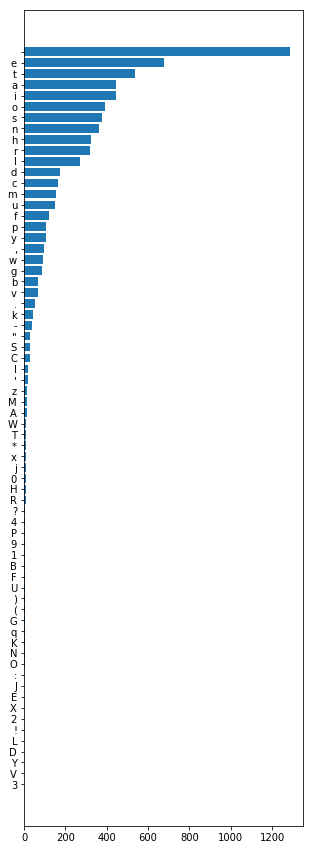

In [8]:
# Count occurences of charcters in the train plaintext
plain_char_cntr = Counter(''.join(train[train.plaintext_id=='ID_4929f84c6']['text'].values))
# new dataframe with frequency and letter
plain_stats = pd.DataFrame([[x[0], x[1]] for x in plain_char_cntr.items()], columns=['Letter', 'Frequency'])
# sort dataframe on occurence of frequency
plain_stats = plain_stats.sort_values(by='Frequency', ascending=True)

# plot
f, ax = plt.subplots(figsize=(5, 15))
plt.barh(np.array(range(len(plain_stats))) + 0.5, plain_stats['Frequency'].values)
plt.yticks(np.array(range(len(plain_stats))) + 0.5, plain_stats['Letter'].values)
plt.show()

### 做頻率分析（密文）

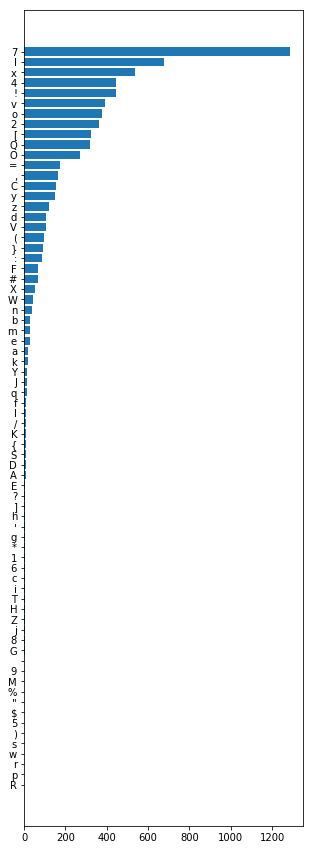

In [9]:
cipher_char_cntr = Counter(''.join(test[test['ciphertext_id'] == 'ID_a6ecf7480']['ciphertext'].values))
cipher_stats = pd.DataFrame([[x[0], x[1]] for x in cipher_char_cntr.items()], columns=['Letter', 'Frequency'])
cipher_stats = cipher_stats.sort_values(by='Frequency', ascending=True)

f, ax = plt.subplots(figsize=(5, 15))
plt.barh(np.array(range(len(cipher_stats))) + 0.5, cipher_stats['Frequency'].values)
plt.yticks(np.array(range(len(cipher_stats))) + 0.5, cipher_stats['Letter'].values)
plt.show()

### 經過分析，此為基本的替換式加密
### 將字母依頻率配對

In [10]:
# merge plaintext frequency stats together with the ciphertext stats based on the Frequency scores
freq_alphabet = pd.merge(plain_stats, cipher_stats, on=['Frequency'])
# sort dataframe on frequency score
freq_alphabet = freq_alphabet.sort_values(by='Frequency', ascending=False)
# print first 20 rows of this dataframe
freq_alphabet.head(20)

,Letter_x,Frequency,Letter_y
197,,1286,7
196,e,679,l
195,a,445,4
194,i,444,!
193,o,390,v
192,s,379,o
191,n,363,2
190,h,325,[
189,r,321,Q
188,l,269,O


### 手動修正並列出字母對應表

In [11]:
cipher = """7lx4v!2oQ[O=,yCzV:}dFX#(Wak/bqne*JApK{cmf6 GZDj9gT\'"YSHiE]5)81hMNwI@P?Us%;30uBrLR-.$t"""
plain =  """ etaoinsrhldcumfygwpb.v,kI\'T"A-SBMxDHj)CW(ELORN!FGPJz0qK?1VY:U92/3*5;478QZ6X%$}#@={[]"""

### 建立加密／解密演算法

In [12]:
decrypt_mapping = {}
encrypt_mapping = {}
for i, j in zip(cipher,plain):
    decrypt_mapping[ord(i)] = ord(j)
    encrypt_mapping[ord(j)] = ord(i)

def encrypt_step1(x):
    return x.translate(encrypt_mapping)

def decrypt_step1(x):
    return x.translate(decrypt_mapping)

In [13]:
# Here is an example
cipher = test[(test['difficulty'] == 1)].sample(1).iloc[0, :]['ciphertext']
print(decrypt_step1(cipher))

#:j4[:gPlM3x6"E)AXm,tU-lP2xgRzI cannot imagine Woody Allen creating a film worse than September. Never has a film been more stagy - Allen must have intended that feeling, but only God knows why. The direction is poor in every way. The dialogue is God awful, often laughable, and the acting is just as bad. Mia Farrow and Dianne Wiest turn in what must be their worst performances. Sam Waterston is ineffective. The two parents (whose names I cannot even recall) seem like their in a different movie - a Woody Allen film. Their delivery is wry and often good, at least it would be if it belonged here. None of the characters ever ring true - never.  What's really sad is that there is a good story underneath this terrible train wreck of a film. Lane's situation and her relationship with the other characters could have been fascinating. Unfortunately, the events of the past are introduced is such a poor way, the same way a really bad play would do it, that they never really seem important. Allen 

# 破解難度2

### 將明文加密至難度1

In [14]:
train['cipher1'] = train['text'].apply(encrypt_step1)
train.head()

,plaintext_id,text,length,length_100,cipher1
index,,,,,
0,ID_b3cc83f06,This movie is one of the very best Christmas m...,258,300,/[!o7Cv#!l7!o7v2l7vz7x[l7#lQV7Flox7m[Q!oxC4o7C...
1,ID_3cb7f9fbd,Would love to see them release the show to a D...,671,700,fvyO=7Ov#l7xv7oll7x[lC7QlOl4ol7x[l7o[v}7xv747p...
2,ID_d7606215e,"Sure, this is a B Movie but it is moody and cr...",770,800,"eyQl(7x[!o7!o747*7Jv#!l7Fyx7!x7!o7Cvv=V742=7,Q..."
3,ID_5d6dda9af,Forget the previous comment by the inknowleagi...,805,900,"gvQ:lx7x[l7dQl#!vyo7,vCCl2x7FV7x[l7!2W2v}Ol4:!..."
4,ID_21e645a25,I taped this masterpiece from the TV about 3 t...,552,600,"a7x4dl=7x[!o7C4oxlQd!l,l7zQvC7x[l7/574Fvyx7w7x..."


In [15]:
# select difficulty 2 ciphertexts
diff2 = test[test['difficulty'] == 2]
# group the ciphertexts by length & sort the values 
lengths = diff2.groupby('length')['ciphertext'].count().sort_values()
# search for those cipher lengths which only once in our ciphertexts set
rare_lengths =  lengths[lengths == 1].index
# match them with the plaintext and count how many times we found a plaintext matching the length of the ciphertexts
train[train['length_100'].isin(rare_lengths)].groupby('length_100')['text'].count()

length_100
6000    14
6200     9
6500     2
6600     3
7100     1
7500     2
7900     1
Name: text, dtype: int64

### 有2組一對一的明文密文

In [16]:
matches = [7100, 7900]
train[train['length_100'].isin(matches)].sort_values('length_100')

,plaintext_id,text,length,length_100,cipher1
index,,,,,
5169,ID_44394ca71,"To the Producers of ""Boudica"" All my life I h...",7045,7100,"/v7x[l7'Qv=y,lQo7vz7b*vy=!,4b77qOO7CV7O!zl7a7[..."
27862,ID_f4d572c54,"JAPAN, 1603: A lone warrior races through the ...",7819,7900,"""q'qj(7]3Sw87q7Ov2l7}4QQ!vQ7Q4,lo7x[Qvy:[7x[l7..."


In [17]:
diff2[diff2['length'].isin(matches)].sort_values('length')

,ciphertext_id,ciphertext,difficulty,length
338,ID_f8d497eb8,"x;@{(-ZFwi%H;e8RPnx0{g$'?vi/j7k[i7'Ui=m,aXc7iw...",2,7100
35903,ID_98caefc04,"!,Bf'D ?m.l]HI}*NrNS{KMgs1R%Oq*}Ur.GhOY'""n'uw(...",2,7900


### 比較其中一組

In [18]:
print("Cipher1 text: ", train[train.plaintext_id=="ID_44394ca71"].cipher1.values[0][0:35], "(generated from the plaintext)")
print("Cipher2 text: ",test[test.ciphertext_id=="ID_f8d497eb8"].ciphertext.values[0][0:35])

Cipher1 text:  /v7x[l7'Qv=y,lQo7vz7b*vy=!,4b77qOO7 (generated from the plaintext)
Cipher2 text:  x;@{(-ZFwi%H;e8RPnx0{g$'?vi/j7k[i7'


In [19]:
print("Cipher1 text: ",train[train.plaintext_id=="ID_44394ca71"].cipher1.values[0][0:35])
print("Cipher2 text: ",test[test.ciphertext_id=="ID_f8d497eb8"].ciphertext.values[0][(55//2):(55//2)+35])

Cipher1 text:  /v7x[l7'Qv=y,lQo7vz7b*vy=!,4b77qOO7
Cipher2 text:  /j7k[i7'Ui=m,aXc7iw7f*im=!,4q77xCB7


### 移除重複的字元

In [20]:
cipher1 = train[train.plaintext_id=="ID_44394ca71"].cipher1.values[0][0:35]
cipher2 = test[test.ciphertext_id=="ID_f8d497eb8"].ciphertext.values[0][(55//2):(55//2)+35]

diff_char1 = ""
diff_char2 = ""
for i in range(len(cipher1)):
    if cipher1[i] != cipher2[i]:
        diff_char1 += cipher1[i]
        diff_char2 += cipher2[i]

print(diff_char1)
print(diff_char2)

vxlQvylQovzbvybqOO
jkiUimaXciwfimqxCB


### 經過分析，應該為多表替換加密（Polyalphabetic cipher）
### 試著找出密鑰

In [21]:
def find_key(cipher2, cipher1, alphabet):
    ciphertext = ''
    for i, c in enumerate(cipher2):
        # check if character is in alphabet
        if c in alphabet:
            # get the index of the cipher2 character in the alphabet
            plain_key = alphabet.index(cipher2[i])
            # do the same for the cipher1 character
            enc_key = alphabet.index(cipher1[i])
            # subtract, but make sure we are still inside the alphabet
            newIndex = (plain_key - enc_key) % len(alphabet)
            # return character from alphabet based on subtracted indices
            ciphertext += alphabet[newIndex]
            #cntr = (cntr + 1) % key_length
        else:
            ciphertext += ""
            
    return ciphertext

find_key(diff_char2, diff_char1, "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")

'ONXeNOPhONXeNOphON'

In [22]:
find_key(diff_char2, diff_char1, 'aAbBcCdDeEfFgGhHiIjJkKlLmMnNoOpPqQrRsStTuUvVwWxXyYzZ')

'onxenophonxenophon'

### 將密鑰設為'xenophon'並建立加密／解密演算法

In [23]:
def encrypt_vigenere(plaintext, key, alphabet):
    key_length = len(key)
    cntr = 0
    ciphertext = ''
    for i, c in enumerate(plaintext):
        if c in alphabet:
            charIndex = alphabet.index(c)
            keyIndex = alphabet.index(key[cntr])
            newIndex = (charIndex + keyIndex) % len(alphabet)
            ciphertext += alphabet[newIndex]
            cntr = (cntr + 1) % key_length
        else:
            ciphertext += c
            
    return ciphertext

def decrypt_vigenere(plaintext, key, alphabet):
    key_length = len(key)
    cntr = 0
    ciphertext = ''
    for i, c in enumerate(plaintext):
        if c in alphabet:
            charIndex = alphabet.index(c)
            keyIndex = alphabet.index(key[cntr])
            newIndex = (charIndex - keyIndex) % len(alphabet)
            ciphertext += alphabet[newIndex]
            cntr = (cntr + 1) % key_length
        else:
            ciphertext += c
            
    return ciphertext

### 試個例子

In [24]:
cipher = test[test.ciphertext_id=="ID_f8d497eb8"].ciphertext.values[0]

step1 = decrypt_vigenere(cipher, 'xenophon', 'aAbBcCdDeEfFgGhHiIjJkKlLmMnNoOpPqQrRsStTuUvVwWxXyYzZ')
step2 = decrypt_step1(step1)

# decrypted text
print(step2[0:76])
# plaintext
print("                          ",train[train.plaintext_id=="ID_44394ca71"].text.values[0][0:76-27])

IZ5j,=y0K]QxZA:?0N'Xj8[P4F"To the Producers of "Boudica"  All my life I have
                           To the Producers of "Boudica"  All my life I have


# 破解難度3

In [28]:
# Difficulty 1
alphabet = """7lx4v!2oQ[O=,yCzV:}dFX#(Wak/bqne*JApK{cmf6 GZDj9gT\'"YSHiE]5)81hMNwI@P?Us%;30uBrLR-.$t"""
key =      """ etaoinsrhldcumfygwpb.v,kI\'T"A-SBMxDHj)CW(ELORN!FGPJz0qK?1VY:U92/3*5;478QZ6X%$}#@={[]"""

decrypt_mapping = {}
encrypt_mapping = {}
for i, j in zip(alphabet, key):
    decrypt_mapping[ord(i)] = ord(j)
    encrypt_mapping[ord(j)] = ord(i)

def encrypt_step1(x):
    return x.translate(encrypt_mapping)

def decrypt_step1(x):
    return x.translate(decrypt_mapping)

# Difficulty 2
def encrypt_step2(plaintext, key='xenophon', alphabet='aAbBcCdDeEfFgGhHiIjJkKlLmMnNoOpPqQrRsStTuUvVwWxXyYzZ'):
    key_length = len(key)
    cntr = 0
    ciphertext = ''
    for i, c in enumerate(plaintext):
        if c in alphabet:
            charIndex = alphabet.index(c)
            keyIndex = alphabet.index(key[cntr])
            newIndex = (charIndex + keyIndex) % len(alphabet)
            ciphertext += alphabet[newIndex]
            cntr = (cntr + 1) % key_length
        else:
            ciphertext += c
            
    return ciphertext

def decrypt_step2(ciphertext, key='xenophon', alphabet='aAbBcCdDeEfFgGhHiIjJkKlLmMnNoOpPqQrRsStTuUvVwWxXyYzZ'):
    key_length = len(key)
    cntr = 0
    plaintext = ''
    for i, c in enumerate(ciphertext):
        if c in alphabet:
            charIndex = alphabet.index(c)
            keyIndex = alphabet.index(key[cntr])
            newIndex = (charIndex - keyIndex) % len(alphabet)
            plaintext += alphabet[newIndex]
            cntr = (cntr + 1) % key_length
        else:
            plaintext += c
            
    return plaintext

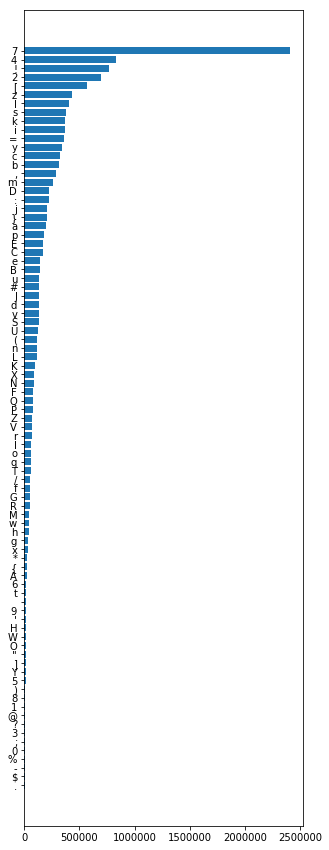

In [25]:
# Count occurences of characters of ciphertexts of difficulty 2
diff2_cntr = Counter(''.join(test[test['difficulty'] == 2]['ciphertext'].values))
# new dataframe with frequency and letter
diff2_stats = pd.DataFrame([[x[0], x[1]] for x in diff2_cntr.items()], columns=['Letter', 'Frequency'])
# sort dataframe on occurence of frequency
diff2_stats = diff2_stats.sort_values(by='Frequency', ascending=True)

# plot
f, ax = plt.subplots(figsize=(5, 15))
plt.barh(np.array(range(len(diff2_stats))) + 0.5, diff2_stats['Frequency'].values)
plt.yticks(np.array(range(len(diff2_stats))) + 0.5, diff2_stats['Letter'].values)
plt.show()

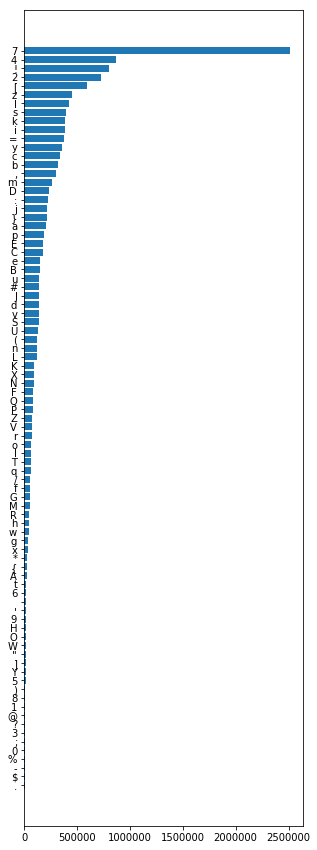

In [26]:
# Count occurences of characters of ciphertexts of difficulty 3
diff3_cntr = Counter(''.join(test[test['difficulty'] == 3]['ciphertext'].values))
# new dataframe with frequency and letter
diff3_stats = pd.DataFrame([[x[0], x[1]] for x in diff3_cntr.items()], columns=['Letter', 'Frequency'])
# sort dataframe on occurence of frequency
diff3_stats = diff3_stats.sort_values(by='Frequency', ascending=True)

# plot
f, ax = plt.subplots(figsize=(5, 15))
plt.barh(np.array(range(len(diff3_stats))) + 0.5, diff3_stats['Frequency'].values)
plt.yticks(np.array(range(len(diff3_stats))) + 0.5, diff3_stats['Letter'].values)
plt.show()

### 依照頻率圖做明文密文的配對（長度=700）

In [36]:
# Let's get all plaintexts of length 700
train_filtered = train[train['length'] == 700]
train_filtered['cipher2'] = train_filtered['text'].apply(lambda x: encrypt_step2(encrypt_step1(x)))

plain_to_cipher = defaultdict(list)
for i, row in tqdm_notebook(train_filtered.iterrows(), total=len(train_filtered)):
    row_cntr = Counter(row['cipher2'])
    test_filtered = test[(test['length'] == len(row['text'])) & (test['difficulty'] == 3)]
    for j, row2 in test_filtered.iterrows():
        row2_cntr = Counter(row2['ciphertext'])
        
        match = True
        for k in row_cntr:
            if k not in row2_cntr or row_cntr[k] != row2_cntr[k]:
                match = False
                break
                
        if match:
            plain_to_cipher[i].append(j)
            break
            
print(plain_to_cipher)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until



defaultdict(<class 'list'>, {5829: [12050], 6608: [12534], 8263: [30312], 11165: [10615], 12737: [19293], 16843: [36135], 17665: [31316], 17756: [1480], 27213: [44067], 27236: [20136], 27859: [38392], 29779: [15372], 35529: [27047], 36616: [7026], 40026: [41255], 40403: [40822]})


### 尋找僅出現一次的字元並回傳其位置

In [37]:
mapping = defaultdict(set)
for k in tqdm_notebook(plain_to_cipher):
    plain_encrypted = train_filtered.loc[k, 'cipher2']
    plain_cntr = Counter(plain_encrypted)
    
    cipher = test.loc[plain_to_cipher[k][0], 'ciphertext']
    cipher_cntr = Counter(cipher)
    
    for key in plain_cntr:
        if plain_cntr[key] == 1 and cipher_cntr[key] == 1:
            mapping[cipher.index(key)].add(plain_encrypted.index(key))
            
for key in sorted(mapping.keys()):
    print(key, mapping[key])


0 {0}
13 {286}
15 {330}
25 {550}
33 {21}
40 {89}
49 {197}
52 {221}
59 {307}
64 {353}
68 {397}
81 {549}
83 {571}
88 {617}
92 {661}
97 {24}
106 {130}
114 {218}
115 {222}
116 {240}
117 {244}
131 {398}
136 {460}
140 {504}
150 {614}
158 {3}
159 {19}
161 {41}
163 {63}
166 {91}
178 {223}
180 {245}
183 {283}
191 {371}
192 {377}
194 {399}
200 {465}
204 {509}
213 {613}
218 {663}
220 {685}
222 {18}
223 {26}
226 {62}
230 {106}
246 {282}
265 {488}
275 {598}
276 {612}
277 {620}
279 {642}
289 {61}
302 {203}
305 {237}
319 {391}
321 {413}
328 {489}
329 {501}
334 {555}
337 {589}
347 {699}
359 {126}
362 {160}
364 {182}
373 {280}
376 {314}
390 {468}
393 {500}
395 {522}
407 {654}
409 {676}
412 {7}
415 {37}
422 {117}
427 {169}
429 {191}
434 {249}
442 {337}
443 {345}
448 {403}
483 {80}
501 {278}
509 {366}
512 {404}
528 {580}
534 {646}
537 {674}
561 {233}
564 {273}
581 {453}
595 {607}
600 {669}
604 {10}
607 {34}
611 {78}
614 {120}
616 {142}
625 {232}
627 {254}
634 {340}
644 {450}
655 {562}
657 {584}
658 {604

### 建立置換表格

In [38]:
def create_table(length, n_cols=22):
    n_rows = int(np.ceil(length / n_cols))
    table = np.zeros((n_rows, n_cols))
    table[:, 0] = list(range(n_rows))
    
    cntr = n_rows - 1
    for col in range(1, n_cols // 2):
        for row in range(n_rows):
            if 0 < (length % n_cols) <= col and row == n_rows - 1:
                table[row, col] = np.NaN
            else:
                cntr += 1
                table[row, col] = cntr
                
            
            if 0 < (length % n_cols) <= 22 - col and row == n_rows - 1:
                table[row, 22 - col] = np.NaN
            else:
                cntr += 1
                table[row, 22 - col] = cntr
            
    for row in range(n_rows):
        if 0 < (length % n_cols) <= n_cols // 2 and row == n_rows - 1:
            table[row, n_cols // 2] = np.NaN
        else:
            cntr += 1
            table[row, n_cols // 2] = cntr
        
    return table

np.set_printoptions(edgeitems=30, linewidth=100000, 
                    formatter=dict(float=lambda x: "% 4g" % x))
create_table(300)

array([[   0,   14,   41,   68,   95,  122,  149,  176,  203,  230,  258,  286,  259,  231,  204,  177,  150,  123,   96,   69,   42,   15],
       [   1,   16,   43,   70,   97,  124,  151,  178,  205,  232,  260,  287,  261,  233,  206,  179,  152,  125,   98,   71,   44,   17],
       [   2,   18,   45,   72,   99,  126,  153,  180,  207,  234,  262,  288,  263,  235,  208,  181,  154,  127,  100,   73,   46,   19],
       [   3,   20,   47,   74,  101,  128,  155,  182,  209,  236,  264,  289,  265,  237,  210,  183,  156,  129,  102,   75,   48,   21],
       [   4,   22,   49,   76,  103,  130,  157,  184,  211,  238,  266,  290,  267,  239,  212,  185,  158,  131,  104,   77,   50,   23],
       [   5,   24,   51,   78,  105,  132,  159,  186,  213,  240,  268,  291,  269,  241,  214,  187,  160,  133,  106,   79,   52,   25],
       [   6,   26,   53,   80,  107,  134,  161,  188,  215,  242,  270,  292,  271,  243,  216,  189,  162,  135,  108,   81,   54,   27],
       [   7,

### 建立加密／解密演算法

In [39]:
def create_map(text, n_cols=22):
    table = create_table(len(text), n_cols=n_cols)
    mapping = {}
    rev_mapping = {}
    for i, c in enumerate(text):
        row_ix, col_ix = [x[0] for x in np.where(table == i)]
        new_pos = row_ix * n_cols + col_ix
        mapping[i] = new_pos
        rev_mapping[new_pos] = i

    return mapping, rev_mapping

def encrypt_step3(text):
    mapping, _ = create_map(text)
    output = ''
    for i, c in enumerate(text):
        output += text[mapping[i]]
    return output

def decrypt_step3(text):
    _, rev_mapping = create_map(text)
    output = ''
    for i, c in enumerate(text):
        output += text[rev_mapping[i]]
    return output

### 試個例子

In [40]:
cipher = test[(test['difficulty'] == 3)].sample(1).iloc[0, :]['ciphertext']
step1 = decrypt_step3(cipher)
step2 = decrypt_step2(step1)
step3 = decrypt_step1(step2)
print(step3)

g$@=1RAa5vlun*ZmxPu7iMvUuyf0"RN1i*hWeird and funny action in South America film. It is the result of collaboration between two rather bright European b movies masters. And it looks more like Franco's film, than Bianchi's. It is one of those banana super actions, with jungle locations, naked women, senseless story. But it has absurd and drive indeed. It looks like comics in some parts and have lo fi special effects amusement. The characters including Howard Vernon are nice and they make that real-time two-weeks made drive. The fans of Commander Strike, Oasis of the zombies will probably love this super-improvised hallucination etc.  www.myspace.com/neizvestSz*R)#At@J:HvM.eA(d$}j1*hy4.NO)1JVjQ
